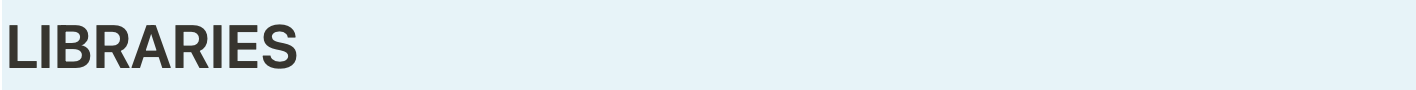

In [22]:
import os, re, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy import ndimage
from skimage.transform import resize, rescale
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation,
    Conv2DTranspose, UpSampling2D, add, BatchNormalization,
    Concatenate, LeakyReLU
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras import layers as L
from tensorflow.keras.utils import plot_model
from keras.saving import register_keras_serializable

# Set random seed for reproducibility
np.random.seed(0)

# Check TensorFlow version
print(tf.__version__)


2.16.1


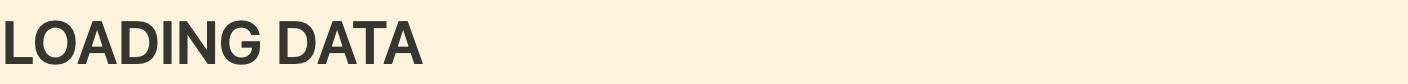

In [23]:


# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/high_res' 
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:810]
validation_low_image = low_img[700:810]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[810:]
test_low_image = low_img[810:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


100%|██████████| 855/855 [00:04<00:00, 195.80it/s]


Shape of training images: (700, 256, 256, 3)
Shape of test images: (45, 256, 256, 3)
Shape of validation images: (110, 256, 256, 3)


# ARCITECTURE OF MODEL 


In [24]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import Model, Input
from keras.saving import register_keras_serializable

@register_keras_serializable(package="resize")
class ResizeByScale(L.Layer):
    def __init__(self, scale, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = float(scale)
        self.method = method
        self.antialias = antialias

    def call(self, x):
        x_dtype = x.dtype
        h = tf.shape(x)[1]; w = tf.shape(x)[2]
        nh = tf.cast(tf.round(tf.cast(h, tf.float32) * self.scale), tf.int32)
        nw = tf.cast(tf.round(tf.cast(w, tf.float32) * self.scale), tf.int32)
        # upcast to f32 for resize (and antialias path), then cast back
        x_f32 = tf.cast(x, tf.float32)
        y = tf.image.resize(x_f32, size=[nh, nw], method=self.method, antialias=self.antialias)
        return tf.cast(y, x_dtype)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"scale": self.scale, "method": self.method, "antialias": self.antialias})
        return cfg


@register_keras_serializable(package="resize")
class ResizeToMatch(L.Layer):
    def __init__(self, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.method = method
        self.antialias = antialias

    def call(self, inputs):
        x, ref = inputs
        x_dtype = x.dtype
        target = tf.shape(ref)[1:3]
        x_f32 = tf.cast(x, tf.float32)
        y = tf.image.resize(x_f32, size=target, method=self.method, antialias=self.antialias)
        return tf.cast(y, x_dtype)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"method": self.method, "antialias": self.antialias})
        return cfg

def conv_block(inputs, nf):
    # LayerNorm is more stable than BN for very small batches
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(inputs)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(x)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    return x

DOWNSCALE = 0.6
down     = ResizeByScale(DOWNSCALE, method="bilinear", antialias=True, name="enc_down")
up_to    = ResizeToMatch(method="bilinear", antialias=True, name="dec_up")

def encoder_block(inputs, nf):
    x = conv_block(inputs, nf)
    p = down(x)
    return x, p

def decoder_block(inputs, skip_features, nf):
    x = up_to([inputs, skip_features])
    x = L.Conv2D(nf, 3, padding='same', activation='relu')(x)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, nf)
    return x

# ---- NEW: Serializable PixelShuffle layer (replaces Lambda) ----
@register_keras_serializable(package="upsample")
class PixelShuffle(L.Layer):
    def __init__(self, r=2, **kwargs):
        super().__init__(**kwargs)
        self.r = int(r)
    def call(self, x):
        return tf.nn.depth_to_space(x, block_size=self.r)
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"r": self.r})
        return cfg

# Sub-pixel (pixel-shuffle) upsampling for final 2x  (no Lambda anymore)
def subpixel_block(x, r=2, nf=64):
    x = L.Conv2D(nf * (r*r), 3, padding='same')(x)
    x = PixelShuffle(r=r, name=f"pixel_shuffle_x{r}")(x)
    x = L.Activation('relu')(x)
    return x
# ---------------------------------------------------------------

# --- replace the final head with a same-size residual head ---

def build_super_resolution_unet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    s1, p1 = encoder_block(inputs,  64)
    s2, p2 = encoder_block(p1,     128)
    s3, p3 = encoder_block(p2,     256)
    s4, p4 = encoder_block(p3,     512)
    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1,  64)

    # ---- SAME-SIZE HEAD (no PixelShuffle) ----
    # Option A: residual prediction (recommended)
    x = conv_block(d4, 64)
    # predict a small residual; zero init => start near identity
    res = L.Conv2D(3, 1, padding="same",
                   kernel_initializer="zeros", bias_initializer="zeros",
                   name="residual_rgb")(x)

    # clip to [0,1] after adding the residual
    def _clip_add(t):
        inp, r = t
        y = tf.cast(inp, tf.float32) + tf.cast(r, tf.float32)
        y = tf.clip_by_value(y, 0.0, 1.0)
        return tf.cast(y, inp.dtype)

    outputs = L.Lambda(_clip_add, name="enhanced_rgb")([inputs, res])

    # ---- Option B (simpler): direct regression head (uncomment if preferred) ----
    # x = conv_block(d4, 64)
    # outputs = L.Activation("sigmoid")(L.Conv2D(3, 1, padding="same")(x))

    return Model(inputs, outputs, name="U-Net_SR_same_size")

model = build_super_resolution_unet((256, 256, 3))
model.summary()


Model: "U-Net_SR_same_size"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_76[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_64[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_77[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_down            │ (None, 33, 33,    │          0 │ activation_65[0]… │
│ (ResizeByScale)     │ 512)              │            │ activation_67[0]… │
│                     │                   │            │ activation_69[0]… │
│                     │                   │            │ activation_71[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 154, 154,  │     73,856 │ enc_down[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 154, 154,  │        256 │ conv2d_78[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 154, 154,  │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 154, 154,  │    147,584 │ activation_66[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 154, 154,  │        256 │ conv2d_79[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 154, 154,  │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 92, 92,    │    295,168 │ enc_down[1][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 92, 92,    │        512 │ conv2d_80[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                 

 Total params: 34,599,363 (131.99 MB)

 Trainable params: 34,599,363 (131.99 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights="imagenet", input_shape=(256, 256, 3))
vgg.trainable = False
feat_extractor = tf.keras.Model(
    inputs=vgg.input,
    outputs=vgg.get_layer("block4_conv4").output,
)

alpha = tf.constant(1.0,  dtype=tf.float32)
beta  = tf.constant(0.1,  dtype=tf.float32)
gamma = tf.constant(0.01, dtype=tf.float32)

def mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    val = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.cast(val, tf.float32)

def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    val = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return tf.cast(val, tf.float32)

def perceptual_loss(y_true, y_pred):
    y_true = tf.cast(tf.clip_by_value(y_true, 0.0, 1.0), tf.float32)
    y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
    feat_true = feat_extractor(preprocess_input(y_true * 255.0))
    feat_pred = feat_extractor(preprocess_input(y_pred * 255.0))
    val = tf.reduce_mean(tf.square(feat_true - feat_pred))
    return tf.cast(val, tf.float32)

def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    total = (
        alpha * mse_loss(y_true, y_pred)
        + beta  * ssim_loss(y_true, y_pred)
        + gamma * perceptual_loss(y_true, y_pred)
    )
    return tf.cast(total, tf.float32)

def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.clip_by_value(y_pred, 0.0, 1.0), tf.float32)
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

In [26]:
# ============================== Optimizer / compile ========================= #
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ===== Compile =====
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[psnr_metric],
)

print("python exec:", sys.executable)
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

python exec: /Users/kunalnarwani/Desktop/Thesis/super-resolution/.venv/bin/python
TF version: 2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, BackupAndRestore

BATCH_SIZE = 4
EPOCHS = 100
SEED = 42  # optional, keeps shuffle deterministic across restarts

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_low_image, train_high_image))
      .shuffle(len(train_low_image), seed=SEED, reshuffle_each_iteration=True)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

valid_ds = (
    tf.data.Dataset.from_tensor_slices((validation_low_image, validation_high_image))
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

MODEL_DIR = "/Users/kunalnarwani/Desktop/Thesis/super-resolution/models"
os.makedirs(MODEL_DIR, exist_ok=True)

early_stop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

model_ckpt = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "best_by_val_loss_0.6.keras"),
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

backup_cb = BackupAndRestore(os.path.join(MODEL_DIR, "train_backup"))

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[early_stop, model_ckpt, backup_cb],
    verbose=2,
)


Epoch 1/100

Epoch 1: val_loss did not improve from inf
175/175 - 441s - 3s/step - loss: inf - psnr_metric: 30.3887 - val_loss: inf - val_psnr_metric: 30.7160
Epoch 2/100

Epoch 2: val_loss did not improve from inf
175/175 - 433s - 2s/step - loss: inf - psnr_metric: 30.9121 - val_loss: inf - val_psnr_metric: 30.8588
Epoch 3/100


KeyboardInterrupt: 

In [29]:
EVAL_BATCH = 8  # adjust for GPU/CPU memory
eval_ds = (
    tf.data.Dataset.from_tensor_slices((validation_low_image, validation_high_image))
      .batch(EVAL_BATCH)
      .prefetch(tf.data.AUTOTUNE)
)

all_psnr, all_ssim, all_msssim = [], [], []
n_images = 0

for lr_b, hr_b in eval_ds:
    pred_b = model(lr_b, training=False)

    if pred_b.shape[1:3] != hr_b.shape[1:3]:  # still guards future changes
        pred_b = tf.image.resize(pred_b, size=hr_b.shape[1:3], method="bicubic")

    hr_tf   = tf.cast(hr_b, tf.float32)
    pred_tf = tf.cast(tf.clip_by_value(pred_b, 0.0, 1.0), tf.float32)

    all_psnr.append(tf.image.psnr(hr_tf, pred_tf, max_val=1.0).numpy())
    all_ssim.append(tf.image.ssim(hr_tf, pred_tf, max_val=1.0).numpy())
    all_msssim.append(tf.image.ssim_multiscale(hr_tf, pred_tf, max_val=1.0).numpy())

    n_images += int(hr_b.shape[0])

def mean_std(x):
    x = np.concatenate(x, axis=0).astype(np.float64)
    return float(np.mean(x)), float(np.std(x))

m_psnr, s_psnr   = mean_std(all_psnr)
m_ssim, s_ssim   = mean_std(all_ssim)
m_msssim, s_msssim = mean_std(all_msssim)

print(f"Validation images evaluated: {n_images}")
print(f" PSNR    : {m_psnr:.4f} ± {s_psnr:.4f} dB")
print(f" SSIM    : {m_ssim:.4f} ± {s_ssim:.4f}")
print(f" MS-SSIM : {m_msssim:.4f} ± {s_msssim:.4f}")


Validation images evaluated: 110
 PSNR    : 31.1567 ± 3.5405 dB
 SSIM    : 0.9250 ± 0.0430
 MS-SSIM : 0.9939 ± 0.0040


2025-09-23 13:03:31.641486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
